# Variational classifier using CircuitQNN



In [26]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from dataset import read_dataset, divide_dataset, balance_dataset

algorithm_globals.random_seed = 42

quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

# Data

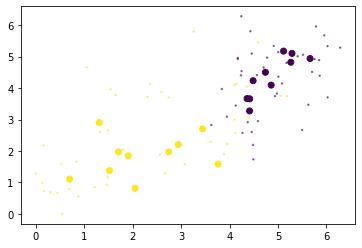

In [27]:
# read the data
dataset = read_dataset()

# extract a balances subset containing a limited number of points
npts = 100
dataset = balance_dataset(dataset, npts)

# only consider a subset of the features
features = [0,1]
nfeatures = len(features)
dataset.features = dataset.features[:,features]

# normalize the data between 0 and 2pi
dataset.features -= dataset.features.min(0)
dataset.features /= dataset.features.max(0)
dataset.features *= 2*np.pi

# divide the dataset in train/test
train_dataset, test_dataset = divide_dataset(dataset, shuffle=False)

# plot the data
plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,alpha=0.5,s=2)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=test_dataset.labels)

# Classification with circuit_qnn

Next we show how a CircuitQNN can be used for classification within a NeuralNetworkClassifier. In this context, the CircuitQNN is expected to return -dimensional probability vector as output, where  denotes the number of classes. Sampling from a QuantumCircuit automatically results in a probability distribution and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping.



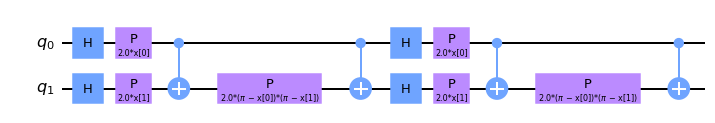

In [28]:
feature_map = ZZFeatureMap(nfeatures,reps=2)
feature_map.decompose().draw(output='mpl')

The RealAplitude Layer is given by: 

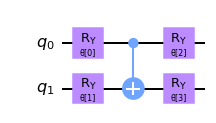

In [29]:
ansatz = RealAmplitudes(nfeatures,reps=1)
ansatz.decompose().draw(output='mpl')

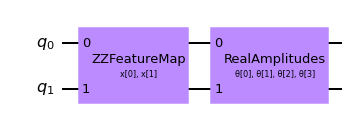

In [30]:
# construct quantum circuit
qc = QuantumCircuit(nfeatures)
qc.append(feature_map, range(nfeatures))
qc.append(ansatz, range(nfeatures))
qc.decompose().draw(output="mpl")

In [31]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [32]:
# construct QNN
circuit_qnn = CircuitQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    quantum_instance=quantum_instance,
)

We will add a callback function called callback_graph. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed.

In [33]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Classification

we can now create the classfier and use it on our data.

In [34]:
# construct classifier
circuit_classifier = NeuralNetworkClassifier(
    neural_network=circuit_qnn, optimizer=COBYLA(), callback=callback_graph
)

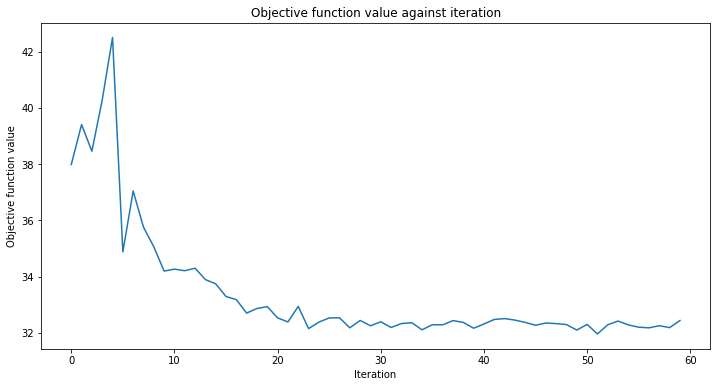

0.65

In [35]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
circuit_classifier.fit(train_dataset.features, train_dataset.labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
circuit_classifier.score(test_dataset.features, test_dataset.labels)

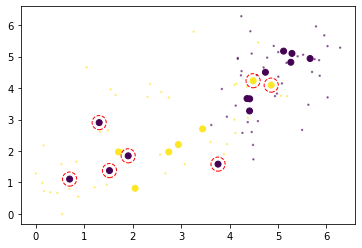

In [36]:
# plot the data
predicted_labels = circuit_classifier.predict(test_dataset.features)

plt.scatter(train_dataset.features[:,0],train_dataset.features[:,1],c=train_dataset.labels,alpha=0.5,s=2)
plt.scatter(test_dataset.features[:,0],test_dataset.features[:,1],c=predicted_labels)
for x, y, yp in zip(test_dataset.features, test_dataset.labels, predicted_labels):
    if y != yp:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linestyle='--',linewidths=1)
        